In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-01-01'

data = yf.download(ticker, start=start_date, end=end_date)
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320429,24.789798,23.879978,24.778675,212818400
2015-01-05,23.635290,24.169170,23.448433,24.089088,257142000
2015-01-06,23.637506,23.897772,23.274912,23.699792,263188400
2015-01-07,23.968958,24.069060,23.735385,23.846610,160423600
2015-01-08,24.889898,24.947736,24.180283,24.298183,237458000


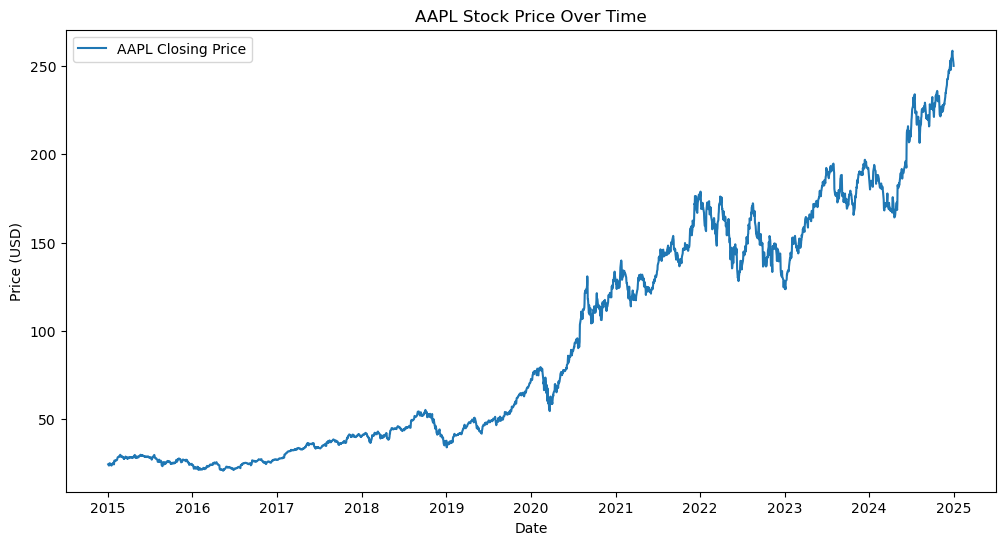

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f'{ticker} Closing Price')
plt.title(f'{ticker} Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [10]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape to 3D for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [30]:
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0190
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0014
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0014
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0013
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0011
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0010
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0010
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 9.8275e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0011
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 8.2376e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.6528e-04
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 8.6239e-04
Epoch 13/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 8.9976e-04
Epoch 14/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.3640e-04
Epoch 15/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms

In [16]:
X_test, y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i])
    y_test.append(test_data[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [18]:
predictions = model.predict(X_test)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


In [20]:
predictions = scaler.inverse_transform(predictions)


In [22]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")


Root Mean Square Error (RMSE): 190.88


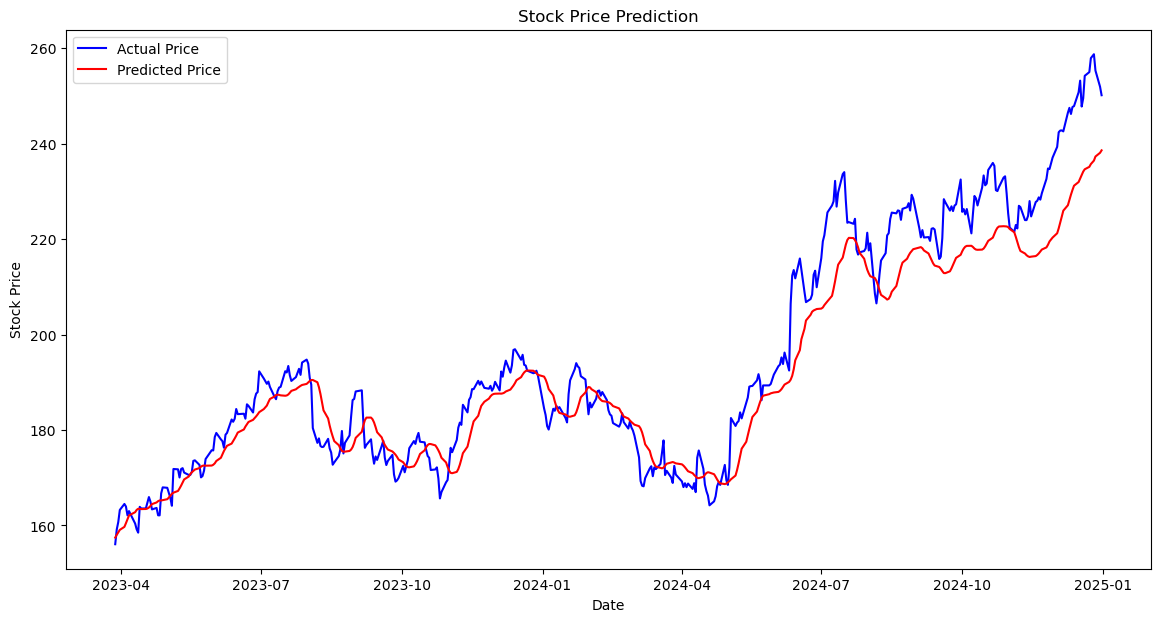

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(data.index[-len(predictions):], predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
